# Assignment: Training EEGNet on P300 EEG Data

In this assignment, you will work with real EEG data from a P300 speller experiment and implement the EEGNet architecture to detect P300 responses. The emphasis of this assignment is on understanding and implementing the EEGNet model rather than extensive signal preprocessing.

**Instructions:**
- Complete the provided code scaffolding
- Fill in missing logic where indicated
- Focus especially on the EEGNet architecture and training


## Part 1: Loading and Inspecting the Dataset

In this section, you will load the EEG dataset and inspect its basic structure. The dataset contains continuous EEG recordings along with stimulus and label information.

In [1]:
import scipy.io as sio
from google.colab import drive
import numpy as np

# Load the dataset
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/BCI_Comp_III_Wads_2004/Subject_A_Train.mat'
data = sio.loadmat(file_path)

# Inspect available keys
print(data.keys())
print(f"Signal Shape:       {data['Signal'].shape}")
print(f"Flashing Shape:     {data['Flashing'].shape}")
print(f"StimulusCode Shape: {data['StimulusCode'].shape}")
print(f"StimulusType Shape: {data['StimulusType'].shape}")
print(f"TargetChar Shape:   {data['TargetChar'].shape}")


Mounted at /content/drive
dict_keys(['__header__', '__version__', '__globals__', 'Signal', 'TargetChar', 'Flashing', 'StimulusCode', 'StimulusType'])
Signal Shape:       (85, 7794, 64)
Flashing Shape:     (85, 7794)
StimulusCode Shape: (85, 7794)
StimulusType Shape: (85, 7794)
TargetChar Shape:   (1,)


## Part 2: Understanding the Experimental Design

The P300 speller paradigm is based on detecting brain responses to rare target stimuli. In this section, you will identify how stimulus timing and labels are encoded in the data.

In [2]:

eeg_signal = data['Signal']
flashing = data['Flashing']
stimulus_code = data['StimulusCode']
stimulus_type = data['StimulusType']
print(f"Assigned EEG Signal shape: {eeg_signal.shape}")
print(f"Assigned Labels shape: {stimulus_type.shape}")

# Hint: Look for variables related to stimulus codes and stimulus types


Assigned EEG Signal shape: (85, 7794, 64)
Assigned Labels shape: (85, 7794)


## Part 3: EEG Epoch Extraction

EEGNet does not operate on continuous EEG. Instead, the signal must be segmented into short epochs following each stimulus. This step converts raw EEG into trials suitable for supervised learning.

In [3]:
def extract_epochs(signal, stimulus_onsets, labels, fs, t_start=0.0, t_end=0.8):
  n_sample_start = int(t_start * fs)
  n_sample_end = int(t_end * fs)
  window_len = n_sample_end - n_sample_start
  num_trials = len(stimulus_onsets)
  epochs = []
  epoch_labels = []
  for i, onset in enumerate(stimulus_onsets):
    start_idx  = onset + n_sample_start
    end_idx = onset + n_sample_end
    if start_idx >= 0 and end_idx <= signal.shape[0]:
      epoch = signal[start_idx:end_idx, :]
      epoch = epoch.T
      epochs.append(epoch)
      epoch_labels.append(labels[i])
  return np.array(epochs), np.array(epoch_labels)

"""
  Extract EEG epochs around each stimulus onset.

 Parameters:
  - signal: continuous EEG array of shape (time, channels)
  - stimulus_onsets: indices where stimuli occur
  - labels: target/non-target labels per stimulus
  - fs: sampling frequency in Hz
  - t_start: start time (seconds) relative to stimulus
  - t_end: end time (seconds) relative to stimulus

 Returns:
  - epochs: array of shape (num_trials, channels, time)
  - y: corresponding labels
  """
  # Hint: Convert time window to samples using fs

'\n  Extract EEG epochs around each stimulus onset.\n\n Parameters:\n  - signal: continuous EEG array of shape (time, channels)\n  - stimulus_onsets: indices where stimuli occur\n  - labels: target/non-target labels per stimulus\n  - fs: sampling frequency in Hz\n  - t_start: start time (seconds) relative to stimulus\n  - t_end: end time (seconds) relative to stimulus\n\n Returns:\n  - epochs: array of shape (num_trials, channels, time)\n  - y: corresponding labels\n  '

## Part 4: Preparing Data for EEGNet

In this section, you will perform minimal preprocessing to make the data compatible with EEGNet. Extensive signal processing is not required.

In [4]:
def prepare_for_eegnet(epochs):
    """
    Prepare EEG epochs for input into EEGNet.

    Expected input shape: (trials, channels, time)
    Expected output shape: (trials, 1, channels, time)
    """
    # Hint: Use numpy.expand_dims
    epochs_expanded = np.expand_dims(epochs, axis=1)
    return epochs_expanded


In [5]:
fs = 240
list_of_epochs = []
list_of_labels = []
num_characters = data['Signal'].shape[0]
for i in range(num_characters):
    curr_signal = data['Signal'][i]
    curr_flashing = data['Flashing'][i]
    curr_stimtype = data['StimulusType'][i]

    # Find where flashing starts (0 -> 1)
    changes = np.diff(curr_flashing, prepend=0)
    onsets = np.where(changes == 1)[0]
    curr_labels = curr_stimtype[onsets]
    ep, lbl = extract_epochs(curr_signal, onsets, curr_labels, fs)

    list_of_epochs.append(ep)
    list_of_labels.append(lbl)
epochs = np.concatenate(list_of_epochs, axis=0)
labels = np.concatenate(list_of_labels, axis=0)
epochs = prepare_for_eegnet(epochs)
print(f"Epochs shape: {epochs.shape}")
print(f"Labels shape: {labels.shape}")

Epochs shape: (15300, 1, 64, 192)
Labels shape: (15300,)


## Part 5: Implementing EEGNet

This is the core part of the assignment. You will implement the EEGNet architecture as discussed in class. Focus on matching the block structure and understanding the role of each layer.

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, DepthwiseConv2D,
                                     SeparableConv2D, BatchNormalization,
                                     AveragePooling2D, Dropout, Flatten,Activation, Dense)
from tensorflow.keras.constraints import max_norm

def EEGNet(nb_classes, Chans, Samples, F1=8, D=2, F2=16, dropoutRate=0.5):

    """
    EEGNet architecture.

    Parameters:
    - nb_classes: number of output classes
    - Chans: number of EEG channels
    - Samples: number of time samples per epoch
    - F1: number of temporal filters
    - D: depth multiplier for spatial filters
    - F2: number of pointwise filters
    """

    inputs = Input(shape=(1, Chans, Samples))

    # Block 1: Temporal Convolution
    block1 = Conv2D(F1, (1, 64), padding='same', use_bias=False,
                    data_format='channels_first')(inputs)
    block1 = BatchNormalization(axis=1)(block1)
    # Block 1: Spatial Convolution
    block1 = DepthwiseConv2D((Chans, 1), use_bias=False,
                             depth_multiplier=D,
                             data_format='channels_first',
                             depthwise_constraint=max_norm(1.))(block1)
    block1 = BatchNormalization(axis=1)(block1)
    block1 = Activation('elu')(block1)
    block1 = AveragePooling2D((1, 4), data_format='channels_first')(block1)
    block1 = Dropout(dropoutRate)(block1)

    # Block 2: Separable Convolution
    block2 = SeparableConv2D(F2, (1, 16), use_bias=False, padding='same',
                             data_format='channels_first')(block1)
    block2 = BatchNormalization(axis=1)(block2)
    block2 = Activation('elu')(block2)
    block2 = AveragePooling2D((1, 8), data_format='channels_first')(block2)
    block2 = Dropout(dropoutRate)(block2)

    # Classification
    flatten = Flatten()(block2)
    outputs = Dense(nb_classes, activation='softmax',
                    kernel_constraint=max_norm(0.25))(flatten)

    return Model(inputs=inputs, outputs=outputs)
chans = epochs.shape[2]
samples = epochs.shape[3]

# 2. Create the model
model = EEGNet(nb_classes=2,
               Chans=chans,
               Samples=samples)


## Part 6: Training the Model

In this section, you will train EEGNet to distinguish between P300 and non-P300 EEG epochs.

In [7]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
y_encoded = to_categorical(labels, num_classes=2)
X = epochs
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded,
                                                  test_size=0.2,
                                                  random_state=42,
                                                  stratify=y_encoded)
print(f"Training shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    batch_size=64,
                    epochs=30,
                    verbose=1)
# Hint: Use categorical cross-entropy and Adam optimizer



Training shape: (12240, 1, 64, 192)
Validation shape: (3060, 1, 64, 192)
Epoch 1/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.7855 - loss: 0.5597 - val_accuracy: 0.8327 - val_loss: 0.4907
Epoch 2/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8397 - loss: 0.4392 - val_accuracy: 0.8317 - val_loss: 0.4298
Epoch 3/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8328 - loss: 0.4273 - val_accuracy: 0.8324 - val_loss: 0.4130
Epoch 4/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8284 - loss: 0.4242 - val_accuracy: 0.8363 - val_loss: 0.4023
Epoch 5/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8353 - loss: 0.4088 - val_accuracy: 0.8386 - val_loss: 0.3996
Epoch 6/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8342 - loss: 0.4033 - val_accuracy: 0.8330 - val_loss: 0.3974
Epoch 7/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8351 - loss: 0.3992 - val_accuracy: 0.8392 - val_loss: 0.3924
Epoch 8/30
192/192 ━━━━

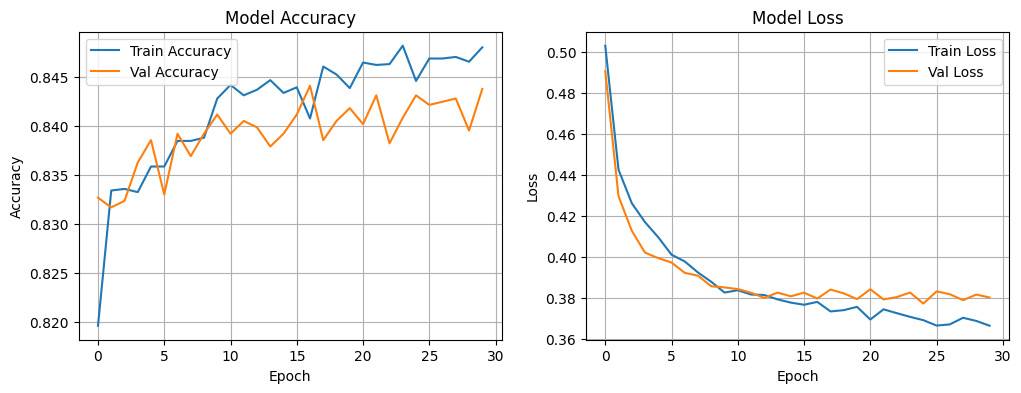

In [10]:
import matplotlib.pyplot as plt

# Plotting the training history
plt.figure(figsize=(12, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()